# Timeseries

In [1]:
from datetime import datetime
import calendar
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
from sklearn.metrics import *

In [3]:
# conversione del dato numerico
#df['datetime'] = pd.to_datetime(df['datetime']) # automatically recognize format
df['datetime'] = pd.to_datetime(df['datetime'], format = '%Y-%m-%d %H:%M:%S')

In [4]:
print(df.info())
df.head(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292 entries, 0 to 291
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  292 non-null    datetime64[ns]
 1   val       292 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.7 KB
None


,datetime,val
0,2020-01-01,42.0
1,2020-01-02,39.0


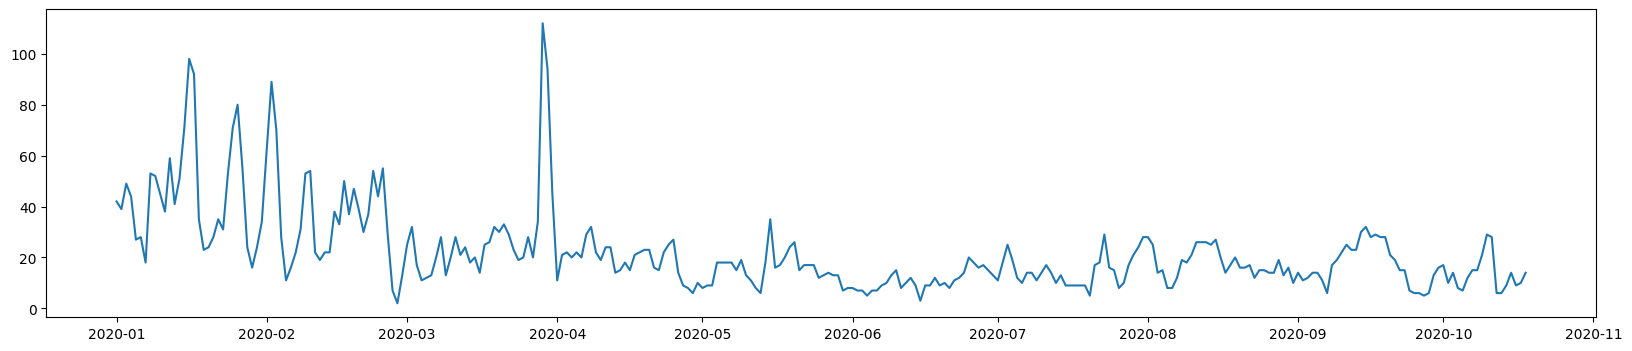

In [5]:
plt.figure(figsize = (20, 4))
plt.plot(df['datetime'], df['val'])
plt.show()

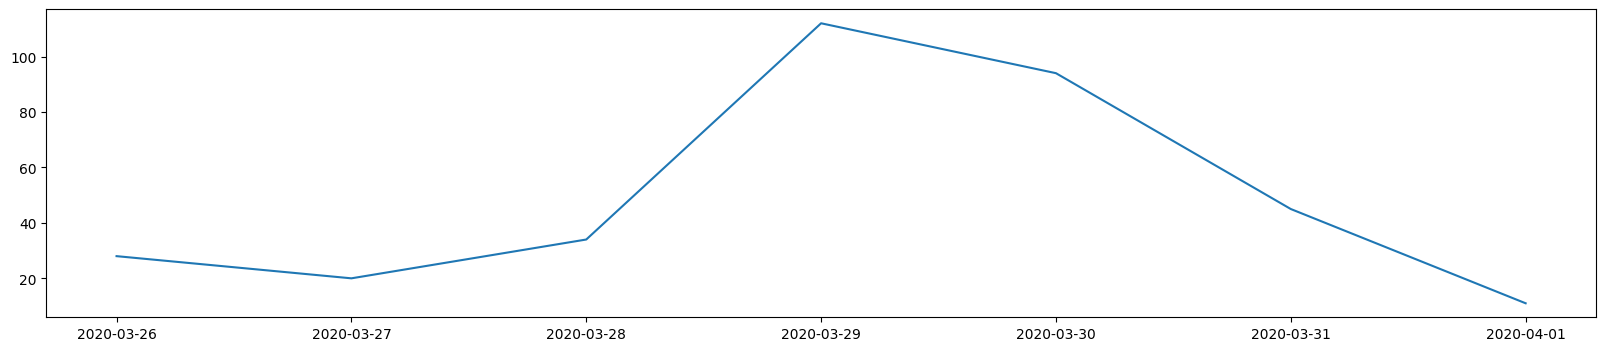

In [6]:
# standard pandas operations apply

start = datetime.strptime('2020-03-25 00:00:00','%Y-%m-%d %H:%M:%S')
end = datetime.strptime('2020-04-2 00:00:00','%Y-%m-%d %H:%M:%S')

df2 = df[(df['datetime']>start)&(df['datetime']<end)]
plt.figure(figsize = (20, 4))
plt.plot(df2['datetime'], df2['val'])
plt.show()

In [7]:
import plotly.express as px
fig = px.line(df, x='datetime', y='val')
fig.show()

## Features

In [8]:
# features based on time

df['month'] = df['datetime'].dt.month
df['weekday'] = df['datetime'].apply(lambda t: calendar.day_name[t.weekday()])
df['weekend01'] = df['weekday'].apply(lambda w: 1  if (w == 'Saturday' or w == 'Sunday') else 0)
df.head(2)

,datetime,val,month,weekday,weekend01
0,2020-01-01,42.0,1,Wednesday,0
1,2020-01-02,39.0,1,Thursday,0


In [10]:
# features based on lag
df['val-1'] = df['val'].shift(1)
df['val-2'] = df['val'].shift(2)
df['val-3'] = df['val'].shift(3)
df.head(5)

,datetime,val,month,weekday,weekend01,val-1,val-2,val-3
0,2020-01-01,42.0,1,Wednesday,0,NaN,NaN,NaN
1,2020-01-02,39.0,1,Thursday,0,42.0,NaN,NaN
2,2020-01-03,49.0,1,Friday,0,39.0,42.0,NaN
3,2020-01-04,44.0,1,Saturday,1,49.0,39.0,42.0
4,2020-01-05,27.0,1,Sunday,1,44.0,49.0,39.0


In [11]:
# fix NaN based on initial shifts
# either remove initial columns
df = df.iloc[3:,:]
# or bfill
#df = df.bfill()
df.head()

,datetime,val,month,weekday,weekend01,val-1,val-2,val-3
3,2020-01-04,44.0,1,Saturday,1,49.0,39.0,42.0
4,2020-01-05,27.0,1,Sunday,1,44.0,49.0,39.0
5,2020-01-06,28.0,1,Monday,0,27.0,44.0,49.0
6,2020-01-07,18.0,1,Tuesday,0,28.0,27.0,44.0
7,2020-01-08,53.0,1,Wednesday,0,18.0,28.0,27.0


In [12]:
# A step beyond adding raw lagged values is to add a summary of the values at previous time
# steps. We can calculate summary statistics across the values in the sliding window and include
# these as features in our dataset. 


# function over a rolling window (e.g., rolling mean)
df['roll3mean'] = df['PM10'].rolling(3).mean()
df.head()

# function over all the values up to the current one (e.g., minimum value so far)
df['min_so_far'] = df['PM10'].expanding().min()
df.head(10)

# difference between current value i-th and a previous value (e.g., diff(2) --> v[i] - v[i-2]) 
df['diff2'] = df['PM10'].diff(2)
df.head(10)

,datetime,PM10,month,weekday,weekend01,PM10-1,PM10-2,PM10-3,roll3mean,min_so_far,diff2
3,2020-01-04,44.0,1,Saturday,1,49.0,39.0,42.0,NaN,44.0,NaN
4,2020-01-05,27.0,1,Sunday,1,44.0,49.0,39.0,NaN,27.0,NaN
5,2020-01-06,28.0,1,Monday,0,27.0,44.0,49.0,33.000000,27.0,-16.0
6,2020-01-07,18.0,1,Tuesday,0,28.0,27.0,44.0,24.333333,18.0,-9.0
7,2020-01-08,53.0,1,Wednesday,0,18.0,28.0,27.0,33.000000,18.0,25.0
8,2020-01-09,52.0,1,Thursday,0,53.0,18.0,28.0,41.000000,18.0,34.0
9,2020-01-10,45.0,1,Friday,0,52.0,53.0,18.0,50.000000,18.0,-8.0
10,2020-01-11,38.0,1,Saturday,1,45.0,52.0,53.0,45.000000,18.0,-14.0
11,2020-01-12,59.0,1,Sunday,1,38.0,45.0,52.0,47.333333,18.0,14.0
12,2020-01-13,41.0,1,Monday,0,59.0,38.0,45.0,46.000000,18.0,3.0


## Forecasting as a Regression Problem

In [13]:
print('min time', df['datetime'].min())
print('max time', df['datetime'].max())
print(df.shape)

min time 2020-01-04 00:00:00
max time 2020-10-18 00:00:00
(289, 11)


In [12]:
# split between train and test
tt_split = datetime.strptime('2020-05-02 00:00:00','%Y-%m-%d %H:%M:%S')
train = df[df['datetime'] <= tt_split]
test = df[df['datetime'] > tt_split]
train.head(4)

,datetime,val,month,weekday,weekend01,val-1,val-2,val-3
3,2020-01-04,44.0,1,Saturday,1,49.0,39.0,42.0
4,2020-01-05,27.0,1,Sunday,1,44.0,49.0,39.0
5,2020-01-06,28.0,1,Monday,0,27.0,44.0,49.0
6,2020-01-07,18.0,1,Tuesday,0,28.0,27.0,44.0


# Linear models on lags, a.k.a. autoregression (AR model)

In [13]:
from sklearn.linear_model import LinearRegression

In [14]:
model = LinearRegression()
model.fit(train.loc[:,['val-1','val-2','val-3','weekend01']], train['val'])

#yp_train = model.predict(train.loc[:,['PM10-1','PM10-2','PM10-3','weekend01']])
yp = model.predict(test.loc[:,['val-1','val-2','val-3','weekend01']])

# note. This is not a pure AR model beccause of the 'weekend01' covariate


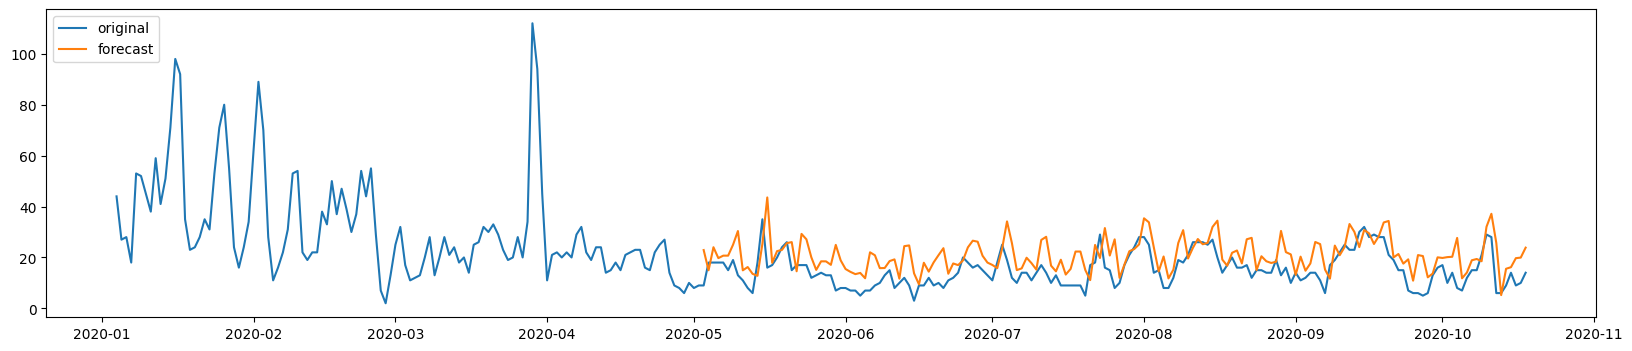

In [15]:
plt.figure(figsize = (20, 4))
plt.plot(df['datetime'],df['val'],label='original')
plt.plot(test['datetime'],yp,label='forecast')
plt.legend(loc="upper left")
plt.show()

In [17]:
print('MAE = ',mean_absolute_error(test['val'],yp))

MAE =  6.784168473816068


In [18]:
from joblib import dump, load
dump(model, 'model.joblib') 
model = load('model.joblib') 
#yp = model.predict(test.loc[:,['PM10-1','PM10-2','PM10-3','weekend01']])
#plt.figure(figsize = (20, 4))
#plt.plot(df['datetime'],df['PM10'],label='original')
#plt.plot(test['datetime'],yp,label='forecast')
#plt.legend(loc="upper left")
#plt.show()

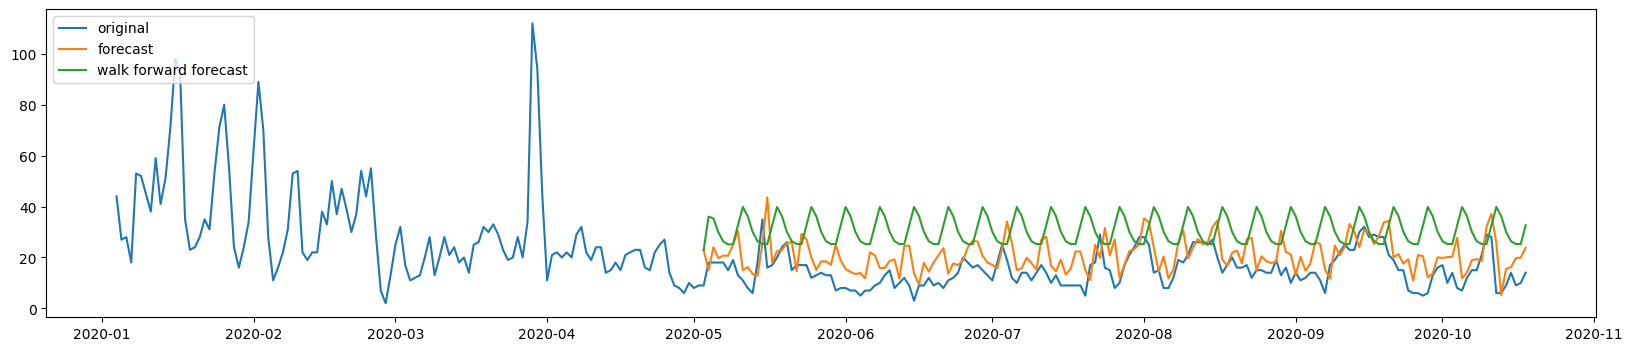

In [19]:
import warnings
warnings.simplefilter(action='ignore', category=UserWarning)

# walk forward predictions, forecast multiple step in advance

last = train.iloc[-1,:]

history = [last['val'],last['val-1'],last['val-2'],last['weekend01']]

#model.predict([history])
predictions =[model.predict([history])[0]]

for t in range(len(test)-1):
    history[2] = history[1]
    history[1] = history[0]
    history[0] = predictions[-1]
    history[3] = test.iloc[t,:]['weekend01']
    predictions.append(model.predict([history])[0])


    
plt.figure(figsize = (20, 4))
plt.plot(df['datetime'],df['val'],label='original')
plt.plot(test['datetime'],yp,label='forecast')
plt.plot(test['datetime'],predictions,label='walk forward forecast')
plt.legend(loc="upper left")
plt.show()

## Extra: Computer Autocorretations

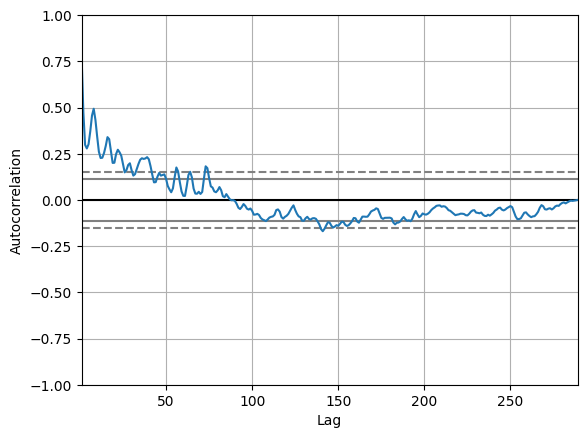

In [21]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df['PM10'])
plt.show()

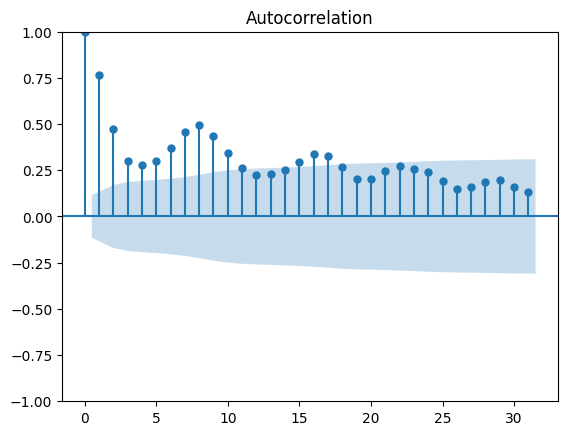

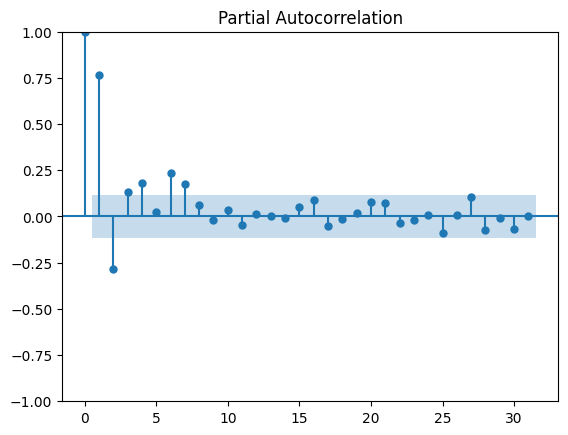

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(df['PM10'], lags=31)
plot_pacf(df['PM10'], lags=31)
plt.show()

## ACF Vs. PACF

* The ACF plots the correlation of the time series with itself at different lags
* Partial autocorrelation measures the correlation between observations at two time points, accounting for the values of the observations at all shorter lags. The PACF plot shows the partial correlation of the time series with itself at different lags.
